In [1]:
# Packages preamble

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.signal as ss
from scipy.signal import argrelextrema

In [6]:
# Imports data

df = pd.read_csv('path/sample_trajectory.csv')
df.columns =['Frame', 'x', 'y']

In [7]:
# Calculates linear and angular speed

time_int = 0.04

df['v_x'] = df.x.diff()/ time_int
df['v_y'] = df.y.diff()/ time_int
df['v'] = np.sqrt(df['v_x']**2 + df['v_y']**2)
df['phi'] = np.arccos(df['v_x']/df['v'])
df['omega'] = np.abs(df.phi.diff()/time_int)

for i in range(len(df['Frame'])):
    if df['Frame'].iloc[i] < df['Frame'].iloc[2]: 
        df = df.dropna()
        break

offset = -3
frames = np.array(df['Frame']) + offset
x = np.array(df['x']) 
y = np.array(df['y'])

In [8]:
# Plots the trajectory. Plots the translational and angular velocity; unfiltered, filtered, and filtered overlaid. 

window = 5
poly = 2

unfiltered_v = df['v']
sg_filtered_v = ss.savgol_filter(unfiltered_v, window, poly)

unfiltered_omega = df['omega']
sg_filtered_omega = ss.savgol_filter(unfiltered_omega, window, poly)

In [9]:
# Creates empty arrays to be filled with for loops

ratio = 0.7

v_min = []
v_max = []

delta_v1 = []
delta_v2 = []
delta_v = []

v_tumble = []
t_tumble = []

# Finds indicies of local minima and maxima

min = argrelextrema(sg_filtered_v, np.less)
max = argrelextrema(sg_filtered_v, np.greater)

# Uses for loops to fill minimum and maximum velocity arrays

for i in range(len(min[0])):
    v_min.append(sg_filtered_v[min[0][i]])

for i in range(len(max[0])):
    v_max.append(sg_filtered_v[max[0][i]])

# Calculates delta_v/v_min for four different data types labeled by case

# Case 1

if len(min[0]) == len(max[0]):
    if min[0][0] < max[0][0]:
        for i in range(len(min[0])-1):
            delta_v1.append(v_max[i+1] - v_min[i+1])
            delta_v2.append(v_max[i] - v_min[i+1])
            
        v_min = np.delete(v_min, 0)
        
        for i in range(len(delta_v1)):
            if delta_v1[i] > delta_v2[i]:
                delta_v.append(delta_v1[i])
            else:
                delta_v.append(delta_v2[i])
        
        v_ratio = np.divide(delta_v, v_min)
        
        for i in range(len(v_ratio)):
            if v_ratio[i] > ratio:
                v_tumble.append(v_min[i])
                t_tumble.append(min[0][i+1]) 

# Case 2

    elif min[0][0] > max[0][0]:
        for i in range(len(min[0])-1):
            delta_v1.append(v_max[i+1] - v_min[i])
            delta_v2.append(v_max[i] - v_min[i])
            
        v_min = np.delete(v_min, -1)
        
        for i in range(len(delta_v1)):
            if delta_v1[i] > delta_v2[i]:
                delta_v.append(delta_v1[i])
            else:
                delta_v.append(delta_v2[i])
        
        v_ratio = np.divide(delta_v, v_min)
        
        for i in range(len(v_ratio)):
            if v_ratio[i] > ratio:
                v_tumble.append(v_min[i])
                t_tumble.append(min[0][i]) 

# Case 3

if len(min[0]) > len(max[0]):
    for i in range(len(min[0])-2):
        delta_v1.append(v_max[i+1] - v_min[i+1]) 
        delta_v2.append(v_max[i] - v_min[i+1])
    
    v_min = np.delete(v_min, 0)
    v_min = np.delete(v_min,-1)
    
    for i in range(len(delta_v1)):
        if delta_v1[i] > delta_v2[i]:
            delta_v.append(delta_v1[i])
        else:
            delta_v.append(delta_v2[i])
    
    v_ratio = np.divide(delta_v, v_min)
    
    for i in range(len(v_ratio)):
        if v_ratio[i] > ratio:
            v_tumble.append(v_min[i])
            t_tumble.append(min[0][i+1])

# Case 4

elif len(min[0]) < len(max[0]): 
    for i in range(len(min[0])):
        delta_v1.append(v_max[i+1] - v_min[i]) 
        delta_v2.append(v_max[i] - v_min[i]) 
    
    for i in range(len(delta_v1)):
        if delta_v1[i] > delta_v2[i]:
            delta_v.append(delta_v1[i])
        else:
            delta_v.append(delta_v2[i])
    
    v_ratio = np.divide(delta_v, v_min)
    
    for i in range(len(v_ratio)):
        if abs(v_ratio[i]) > ratio:
            v_tumble.append(v_min[i])
            t_tumble.append(min[0][i]) 

In [10]:
# Calculates adjacent maxima for four different data types labeled by case

tumble_time = np.zeros(len(v_tumble))
run_time = np.zeros(len(t_tumble)+1)
adj_max = []
tumble_frames = []
run_frames = []
tumble_dots_x = []
tumble_dots_y = []

threshold = 0.3

# Case 1

if len(min[0]) == len(max[0]):
    if min[0][0] < max[0][0]: 
        for i in range(len(t_tumble)): 
            for j in range(len(min[0])): 
                if t_tumble[i] == min[0][j]: 
                    for k in range(len(max[0])): 
                        if max[0][k] < min[0][j] and max[0][k] > min[0][j-1]: 
                            adj_max.append(max[0][k]) 
                        if max[0][k] > min[0][j]: 
                            if len(min[0]) == j+1: 
                                adj_max.append(max[0][k]) 
                            elif max[0][k] < min[0][j+1]: 
                                adj_max.append(max[0][k])

# Case 2

    elif min[0][0] > max[0][0]:
        for i in range(len(t_tumble)):
            for j in range(len(min[0])):
                if t_tumble[i] == min[0][j]:
                    for k in range(len(max[0])):
                        if max[0][k] < min[0][j]:
                            if j == 0:
                                adj_max.append(max[0][k]) 
                            elif max[0][k] > min[0][j-1]:
                                adj_max.append(max[0][k])
                        if max[0][k] > min[0][j] and max[0][k] < min[0][j+1]:
                                adj_max.append(max[0][k]) 
                                    
# Case 3

if len(min[0]) > len(max[0]):
    for i in range(len(t_tumble)):
        for j in range(len(min[0])):
            if t_tumble[i] == min[0][j]:
                for k in range(len(max[0])):
                    if max[0][k] < min[0][j] and max[0][k] > min[0][j-1]:
                        adj_max.append(max[0][k])
                    if max[0][k] > min[0][j] and max[0][k] < min[0][j+1]:
                        adj_max.append(max[0][k])

# Case 4
    
elif len(min[0]) < len(max[0]): 
    for i in range(len(t_tumble)):
        for j in range(len(min[0])):
            if t_tumble[i] == min[0][j]:
                for k in range(len(max[0])):
                    if max[0][k] < min[0][j]:
                            if j == 0:
                                adj_max.append(max[0][k]) 
                            elif max[0][k] > min[0][j-1]:
                                adj_max.append(max[0][k]) 
                    elif max[0][k] > min[0][j]: 
                            if len(min[0]) == j+1: 
                                adj_max.append(max[0][k]) 
                            elif max[0][k] < min[0][j+1]: 
                                adj_max.append(max[0][k]) 

adj_max.sort()

# Calculates tumble times (case independent)

for i in range(len(v_tumble)):
    for j in range(len(frames)):
        if frames[j] >= adj_max[2*i] and frames[j] <= adj_max[2*i+1]:
            for k in range(len(v_min)):
                if v_tumble[i] == v_min[k]:
                    if sg_filtered_v[j] <= v_tumble[i] + threshold * delta_v[k]: 
                        if j not in tumble_frames:
                            tumble_frames.append(j)
                            tumble_dots_x.append(x[j])
                            tumble_dots_y.append(y[j])
                            tumble_time[i] = time_int + tumble_time[i]

# Calculates run times (case independent). Includes re-alignment of the rt array in special cases when two tumbles need to be added together.

i = 0

for j in range(len(frames)):
        if frames[j] not in tumble_frames:
                run_frames.append(j)
                run_time[i] = run_time[i] + time_int
        elif frames[j-1] not in tumble_frames:
            i += 1
        else: 
            for k in range(len(adj_max)):
                if adj_max[k] == frames[j]:
                    if frames[j] in tumble_frames and frames[j-1] in tumble_frames and frames[j+1] in tumble_frames:
                        if run_time[i-1] != 0:
                            run_time[i] = 0 
                            i += 1
            
run_time = np.delete(run_time, 0)
run_time = np.delete(run_time,-1)

In [11]:
# Calculates tumble angles

dif_ix_arr = []
dif_iy_arr = []
dif_ox_arr = []
dif_oy_arr = []
iphi_arr = []
ophi_arr = []
tumble_angles = []

for i in range(len(tumble_frames)):
    
    for j in range(len(frames)):
        
        h = tumble_frames[i]
        
        if tumble_frames[i] == frames[j]:
            
            if h-1 not in tumble_frames:
                dif_ix = x[j-1] - x[j-3]
                dif_iy = y[j-1] - y[j-3]
                dif_ix_arr.append(dif_ix)
                dif_iy_arr.append(dif_iy)
                iv_x = dif_ix / time_int
                iv_y = dif_iy / time_int
                iv = np.sqrt(iv_x**2 + iv_y**2)
                iphi = np.arccos(iv_x/iv)
                iphi_arr.append(iphi * (180/math.pi))    
            
            if h+1 not in tumble_frames:
            
                dif_ox = x[j+2] - x[j] 
                dif_oy = y[j+2] - y[j]
                dif_ox_arr.append(dif_ox)
                dif_oy_arr.append(dif_oy)
                ov_x = dif_ox / time_int
                ov_y = dif_oy / time_int
                ov = np.sqrt(ov_x**2 + ov_y**2)
                ophi = np.arccos(ov_x/ov)
                ophi_arr.append(ophi * (180/math.pi))
                
n = 0

for i in range(len(tumble_time)):
    
    if run_time[i-1] != 0:
        
        if dif_iy_arr[i-n] > 0 and dif_oy_arr[i-n] > 0:

            if abs(ophi_arr[i-n]-iphi_arr[i-n]) <= 180:
                tumble_angles.append(round(abs(ophi_arr[i-n]-iphi_arr[i-n]), 2))

            elif abs(ophi_arr[i-n]-iphi_arr[i-n]) > 180: #this condition is for angles that are between 180 and 360. these should be subtracted from 360, and the sign should be positive for all of these (to keep consistent), in order to keep the angle as 180 - ImageJ angle output.
                tumble_angles.append(round(abs(360-abs(ophi_arr[i-n]-iphi_arr[i-n])), 2))

        if dif_iy_arr[i-n] > 0 and dif_oy_arr[i-n] < 0:

            if abs(-ophi_arr[i-n]-iphi_arr[i-n]) <= 180:
                tumble_angles.append(round(abs(-ophi_arr[i-n]-iphi_arr[i-n]), 2))

            elif abs(-ophi_arr[i-n]-iphi_arr[i-n]) > 180:
                tumble_angles.append(round(abs(360-abs(-ophi_arr[i-n]-iphi_arr[i-n])), 2))

        if dif_iy_arr[i-n] < 0 and dif_oy_arr[i-n] > 0:

            if abs(ophi_arr[i-n]+iphi_arr[i-n]) <= 180:
                tumble_angles.append(round(abs(ophi_arr[i-n]+iphi_arr[i-n]), 2))

            elif abs(ophi_arr[i-n]+iphi_arr[i-n]) > 180:
                tumble_angles.append(round(abs(360-abs(ophi_arr[i-n]+iphi_arr[i-n])), 2))

        if dif_iy_arr[i-n] < 0 and dif_oy_arr[i-n] < 0:

            if abs(-ophi_arr[i-n]+iphi_arr[i-n]) <= 180:
                tumble_angles.append(round(abs(-ophi_arr[i-n]+iphi_arr[i-n]), 2))

            elif abs(-ophi_arr[i-n]+iphi_arr[i-n]) > 180:
                tumble_angles.append(round(abs(360-abs(-ophi_arr[i-n]+iphi_arr[i-n])), 2))
    
    else:
        
        tumble_angles.append('See previous entry')                            
        n += 1

In [12]:
# Calculates average velocity

vels = [] 
velslongruns = []
velsshortruns = []
longrunthreshold = 6 # e.g., if longrunthreshold = 6, only runs of 5 or more frames in length are counted

s = 0
for k in range(len(frames)):
    for i in range(len(tumble_frames)):
        for j in range(len(run_frames)):
            if tumble_frames[i] >= tumble_frames[i-1] + longrunthreshold: 
                if run_frames[j] == frames[k]:
                    if run_frames[j] > tumble_frames[i-1] and run_frames[j] < tumble_frames[i]:
                        vels.append(sg_filtered_v[k]) 
                        s += 1
                        
            else: 
                if run_frames[j] == frames[k]:
                    if run_frames[j] > tumble_frames[i-1] and run_frames[j] < tumble_frames[i]:
                        vels.append(0) 
                        s += 1

longrunpresent = False

for i in range(len(vels)):
    if vels[i] != 0:
        longrunpresent = True
        
s = 0

if longrunpresent == True: 
    for i in range(len(vels)):
        if vels[i] != 0:
            velslongruns.append(vels[i])
    avgvel = sum(velslongruns) / len(velslongruns)

else:
    for k in range(len(frames)):
        for i in range(len(tumble_frames)):
            for j in range(len(run_frames)):
                if run_frames[j] == frames[k]:
                    if run_frames[j] > tumble_frames[i-1] and run_frames[j] < tumble_frames[i]:
                        velsshortruns.append(sg_filtered_v[k])
                        s += 1
    avgvel = sum(velsshortruns) / len(velsshortruns)

print('The average run velocity is:', np.round(avgvel,1), 'μm/s')

The average run velocity is: 26.6 μm/s


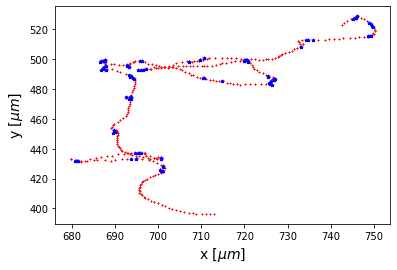

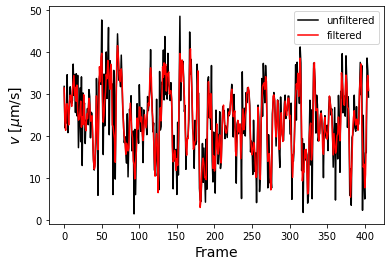

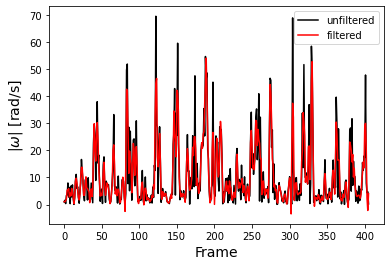

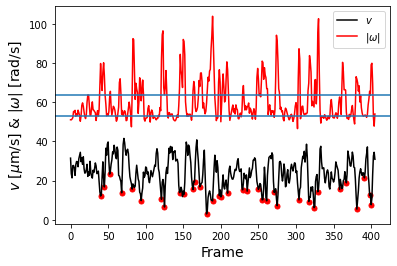

The tumble times are:
 
 [0.12 0.08 0.08 0.12 0.16 0.16 0.08 0.04 0.16 0.12 0.16 0.04 0.24 0.16
 0.08 0.08 0.08 0.08 0.08 0.04 0.2  0.12 0.08 0.16 0.12 0.16 0.08 0.08
 0.08 0.04 0.12 0.12 0.16 0.12 0.08] 

The tumble angles are (deg.): 
 
 ['See previous entry', 2.79, 69.74, 26.34, 155.52, 32.54, 110.89, 47.89, 31.65, 23.81, 27.92, 'See previous entry', 45.49, 53.44, 143.03, 138.5, 'See previous entry', 100.07, 70.4, 2.06, 17.23, 39.24, 23.5, 8.25, 'See previous entry', 83.27, 167.45, 7.4, 23.89, 33.21, 26.76, 54.58, 53.17, 20.68, 'See previous entry'] 

The run times are: 
 
 [0.08 0.24 0.48 0.44 0.32 0.96 0.12 0.72 0.08 0.32 0.   0.2  0.12 0.16
 0.32 0.   0.24 0.72 0.2  0.48 0.04 0.12 0.32 0.   1.04 0.4  0.2  0.12
 1.08 0.28 0.44 0.24 0.16 0.  ]


In [16]:
# Plots relevant parameters. Frames in python are 4 frames behind. 

plt.figure()
plt.scatter(x, y, color = 'red', s=1, marker='x')
plt.scatter(tumble_dots_x, tumble_dots_y, color = 'blue', s=10, marker='*')
plt.xlabel(r'x [$\mu m$]', fontsize = 14)
plt.ylabel(r'y [$\mu m$]', fontsize = 14)
plt.show()

plt.figure()
plt.plot(frames, unfiltered_v, color = 'black', label = 'unfiltered')
plt.plot(sg_filtered_v, color = 'red', label = 'filtered', alpha = 1)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel(r'$v$ [$\mu$m/s]', fontsize = 14)
plt.legend()
plt.show()

plt.figure()
plt.plot(frames, unfiltered_omega, color = 'black', label = 'unfiltered')
plt.plot(sg_filtered_omega, color = 'red', label = 'filtered', alpha = 1)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel(r'|$\omega$| [rad/s]', fontsize = 14)
plt.legend()
plt.show()

offset = 50
percent = 0.2
baseline = 3 + offset
percent_line = baseline + baseline*percent

plt.figure()
plt.plot(sg_filtered_v, color = 'black', label = r'$v$')
plt.plot(sg_filtered_omega+offset, color = 'red', label = r'$|\omega|$', alpha = 1)
plt.axhline(y=baseline)
plt.axhline(y=percent_line)

plt.scatter(t_tumble, v_tumble, color = 'red', s = 25)
plt.xlabel('Frame', fontsize = 14)
plt.ylabel(r'$v$ [$\mu$m/s] & |$\omega$| [rad/s]', fontsize = 14)
plt.legend()
plt.show()

print('The tumble times are:\n \n',tumble_time, '\n')
print('The tumble angles are (deg.): \n \n', tumble_angles, '\n') 
print('The run times are: \n \n', run_time)